# ODIR-5K Data Exploration

## Objective
This notebook performs an initial exploration of the ODIR-5K dataset to:
- Understand dataset structure
- Inspect label distribution
- Verify training vs testing separation
- Confirm image–label mappings
- Identify class imbalance

This step is critical to ensure correct downstream training, validation, and evaluation.

## Section 1 - Import Required Libraries and set paths

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

# Display settings
pd.set_option("display.max_columns", None)
plt.style.use("default")

## Define Dataset Paths

We explicitly define paths to avoid hardcoding and ensure reproducibility.

In [5]:
# Get project root (assumes notebook is inside /notebooks)
PROJECT_ROOT = Path.cwd().parent

# Data directory
DATA_DIR = PROJECT_ROOT / "data"

# ODIR dataset directory (matches your actual path)
ODIR_DIR = DATA_DIR / "ODIR-5K" / "ODIR-5K"

# Image directories
TRAIN_IMG_DIR = ODIR_DIR / "Training Images"
TEST_IMG_DIR = ODIR_DIR / "Testing Images"

# Label file
LABEL_FILE = ODIR_DIR / "data.xlsx"

# Sanity checks
assert LABEL_FILE.exists(), f"data.xlsx not found at {LABEL_FILE}"
assert TRAIN_IMG_DIR.exists(), "Training Images folder not found!"
assert TEST_IMG_DIR.exists(), "Testing Images folder not found!"

print("All dataset paths verified successfully.")

All dataset paths verified successfully.


## Load Official Label File (`data.xlsx`)

This file contains the authoritative ground-truth annotations provided by the dataset authors.

In [6]:
# Load the official ODIR label file
df = pd.read_excel(LABEL_FILE)

# Display basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         3500 non-null   int64 
 1   Patient Age                3500 non-null   int64 
 2   Patient Sex                3500 non-null   object
 3   Left-Fundus                3500 non-null   object
 4   Right-Fundus               3500 non-null   object
 5   Left-Diagnostic Keywords   3500 non-null   object
 6   Right-Diagnostic Keywords  3500 non-null   object
 7   N                          3500 non-null   int64 
 8   D                          3500 non-null   int64 
 9   G                          3500 non-null   int64 
 10  C                          3500 non-null   int64 
 11  A                          3500 non-null   int64 
 12  H                          3500 non-null   int64 
 13  M                          3500 non-null   int64 
 14  O       

## Section 2 - Inspect Dataset Structure

We examine the columns to understand:
- Patient metadata
- Image filenames
- Disease labels

In [7]:
# Show first few rows
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


## Disease Label Columns

ODIR-5K is a **multi-label classification** dataset with the following disease indicators:

- N: Normal
- D: Diabetes
- G: Glaucoma
- C: Cataract
- A: Age-related Macular Degeneration
- H: Hypertension
- M: Pathological Myopia
- O: Other abnormalities

Each label is binary (0 or 1).

In [8]:
# List label columns
label_cols = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# Confirm labels exist
assert all(col in df.columns for col in label_cols), "Missing label columns!"

# Count positives per label
label_counts = df[label_cols].sum().sort_values(ascending=False)
label_counts

N    1140
D    1128
O     979
G     215
C     212
M     174
A     164
H     103
dtype: int64

## Section 3 - Class Imbalance Analysis

Medical datasets are naturally imbalanced. We visualize disease frequency to understand training challenges.

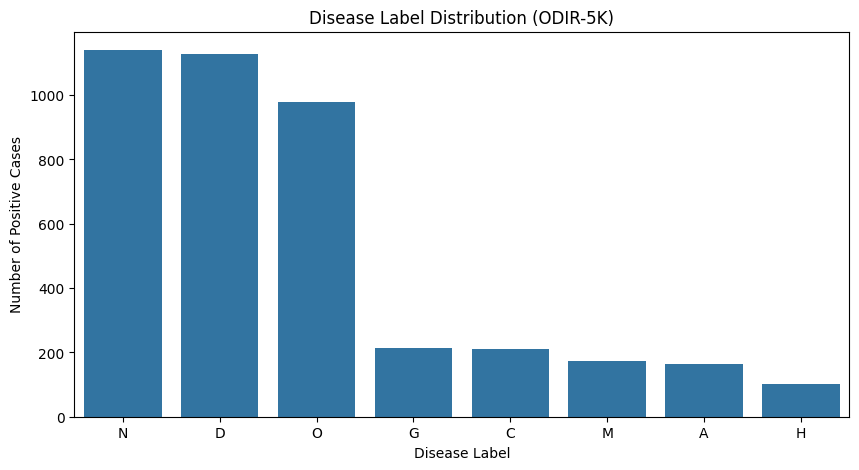

In [9]:
# Bar Plot of Labels
plt.figure(figsize=(10, 5))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Disease Label Distribution (ODIR-5K)")
plt.ylabel("Number of Positive Cases")
plt.xlabel("Disease Label")
plt.show()

## Section 4 - Verify Training vs Testing Image Separation

We ensure the dataset respects the official separation to avoid data leakage.

In [10]:
# Count Images
train_images = sorted(os.listdir(TRAIN_IMG_DIR))
test_images = sorted(os.listdir(TEST_IMG_DIR))

print(f"Number of training images: {len(train_images)}")
print(f"Number of testing images: {len(test_images)}")

Number of training images: 7000
Number of testing images: 1000


## Section 5 - Verify Image Filenames in `data.xlsx`

Each patient has:
- Left eye image
- Right eye image

We verify that filenames in `data.xlsx` actually exist in the image folders.

In [11]:
# Columns that contain image filenames
image_cols = ['Left-Fundus', 'Right-Fundus']

missing_files = []

for col in image_cols:
    for fname in df[col]:
        if fname not in train_images and fname not in test_images:
            missing_files.append(fname)

print(f"Missing image files: {len(missing_files)}")

Missing image files: 0


## Section 6 - Multi-Label Nature Check

We inspect how many diseases each patient has.

In [12]:
# Number of diseases per patient
df["num_labels"] = df[label_cols].sum(axis=1)
df["num_labels"].value_counts().sort_index()

num_labels
1    2914
2     557
3      29
Name: count, dtype: int64

## Section 7 - Distribution of Disease Count per Patient

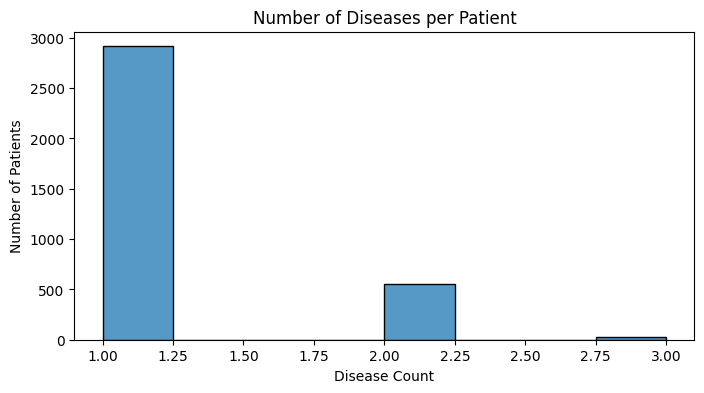

In [13]:
# Histogram
plt.figure(figsize=(8, 4))
sns.histplot(df["num_labels"], bins=8)
plt.title("Number of Diseases per Patient")
plt.xlabel("Disease Count")
plt.ylabel("Number of Patients")
plt.show()

## Key Findings

- The ODIR-5K dataset is a **multi-label ophthalmic classification problem** with **8 disease categories**.
- There is **strong class imbalance**, with Normal (N), Diabetes (D), and Other (O) dominating the dataset, while Glaucoma (G), Cataract (C), AMD (A), Hypertension (H), and Pathological Myopia (M) are underrepresented.
- Most patients have **a single diagnosed condition** (2,914 cases), with fewer patients exhibiting multiple co-occurring diseases (557 with two, 29 with three).
- The dataset contains **7,000 training images** and **1,000 testing images**, following an official and strict separation.
- These characteristics motivate the use of **transfer learning**, **multi-label loss functions**, and **AUC-based evaluation metrics** rather than accuracy.